<a href="https://colab.research.google.com/github/merge-ai/disentangling_conditional_gans/blob/master/Developing_an_AC_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook we will work on auxiliary GANs which is an extension of the cGAN that makes the training of the GAN more stable and also produces high quality images. 
  *This is done by simply allowing the discriminator to not only predict whether or not an image is real or fake, but also determining the correct class label. 

In [0]:
%tensorflow_version 1.x
import tensorflow as tf
print(tf.__version__)

TensorFlow 1.x selected.
1.15.2


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 14, 14, 32)   320         input_4[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_2 (LeakyReLU)       (None, 14, 14, 32)   0           conv2d_3[0][0]                   
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 14, 14, 32)   0           leaky_re_lu_2[0][0]              
____________________________________________________________________________________________

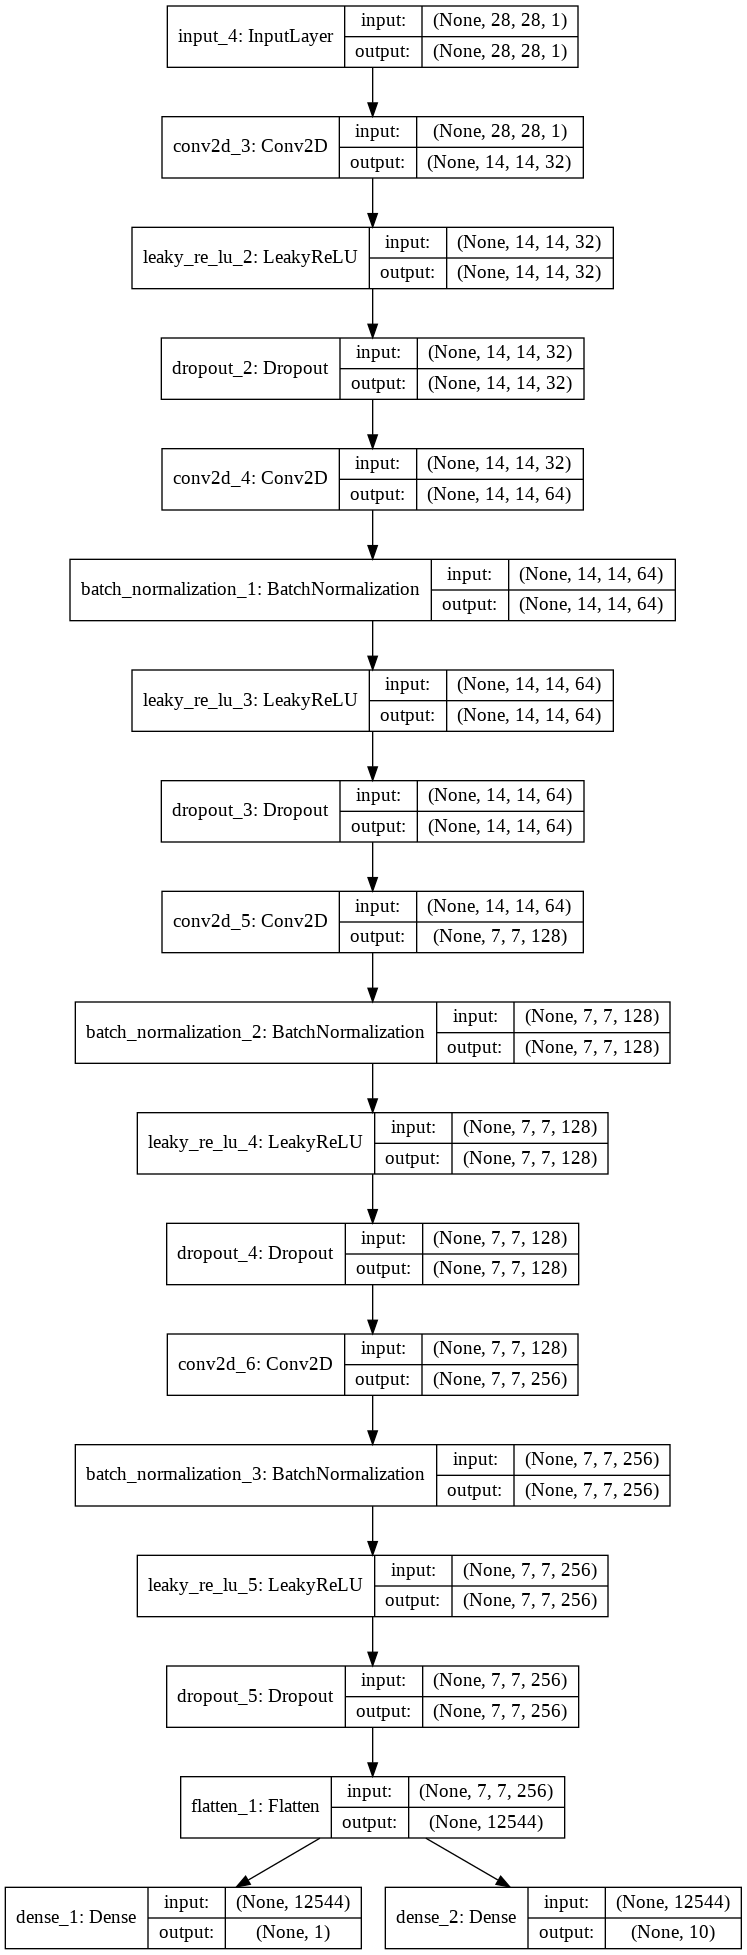

In [0]:
#HOW TO DEFINE AC-GAN MODELS
#example of defining the Discriminator model 
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import BatchNormalization 
from keras.initializers import RandomNormal
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model

#define the standalone discriminator model 
def define_discriminator(in_shape=(28,28,1), n_classes=10):
  #weight initialization
  init= RandomNormal(stddev= 0.02)
  #image input
  in_image= Input(shape= in_shape)
  #downasmaple to 14x14
  fe= Conv2D(32,(3,3), strides=(2,2), padding='same', kernel_initializer=init)(in_image)
  fe= LeakyReLU(alpha= 0.2)(fe)
  fe= Dropout(0.5)(fe)
  #normal
  fe= Conv2D(64,(3,3), padding= 'same', kernel_initializer= init)(fe)
  fe= BatchNormalization()(fe)
  fe= LeakyReLU(alpha=0.2)(fe)
  fe= Dropout(0.5)(fe)
  #downsample to 7x7
  fe= Conv2D(128,(3,3), strides=(2,2), padding='same', kernel_initializer= init)(fe)
  fe= BatchNormalization()(fe)
  fe= LeakyReLU(alpha= 0.2)(fe)
  fe= Dropout(0.5)(fe)
  #normal 
  fe= Conv2D(256, (3,3), padding= 'same', kernel_initializer= init)(fe)
  fe= BatchNormalization()(fe)
  fe= LeakyReLU(alpha= 0.2)(fe)
  fe= Dropout(0.5)(fe)
  #flatten feature maps
  fe= Flatten()(fe)
  #real/fake output
  out1= Dense(1, activation= 'sigmoid')(fe)
  #class label output
  out2= Dense(n_classes, activation= 'softmax')(fe)
  #define model
  model= Model(in_image, [out1, out2])
  #compile model
  opt= Adam(lr= 0.0002, beta_1= 0.5)
  model.compile(loss= ['binary_crossentropy', 'sparse_categorical_crossentropy'], optimizer= opt)
  return model

#define the discriminator model
model= define_discriminator()
#summarize the model
model.summary()
#plot the model
plot_model(model, to_file= 'discriminator_plot.png', show_shapes= True)

#NOW LETS DEFINE OUR GENERATOR MODEL


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 18816)        1900416     input_6[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 50)        500         input_5[0][0]                    
____________________________________________________________________________________________

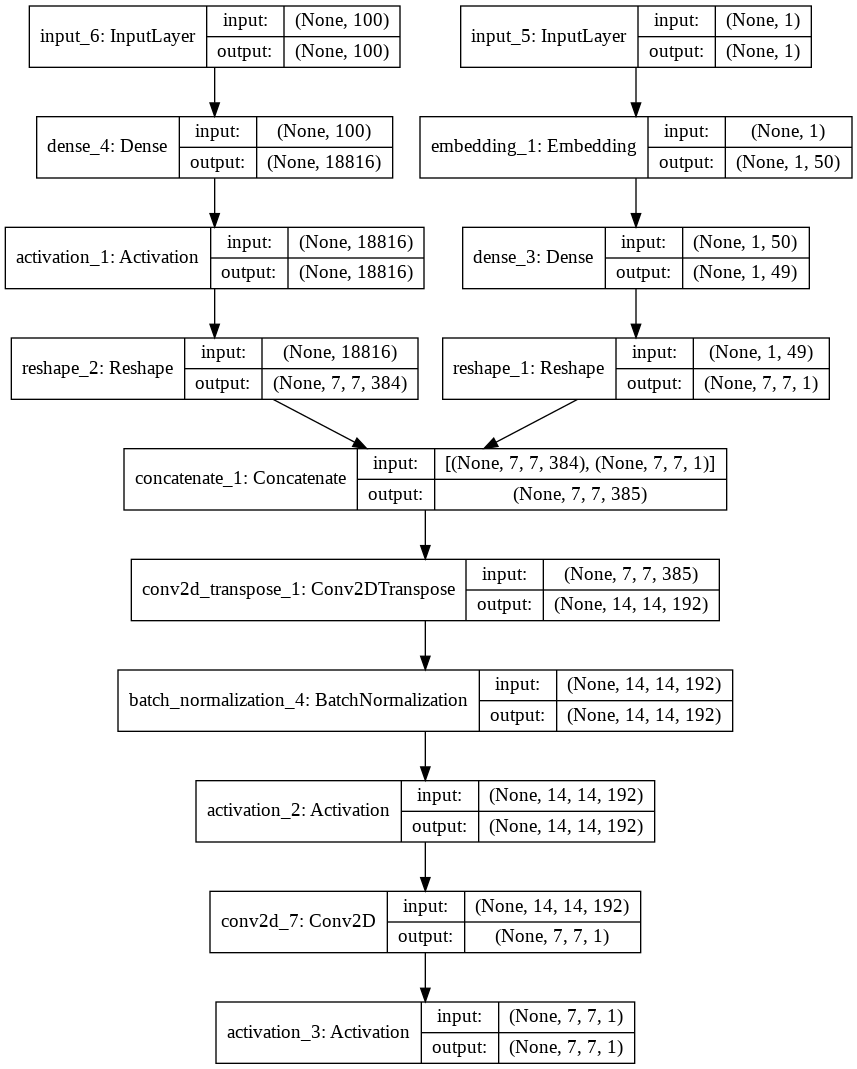

In [0]:
#example of defining the generator model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Conv2DTranspose
from keras.layers import Embedding
from keras.layers import Concatenate
from keras.layers import Activation
from keras.layers import BatchNormalization
from keras.initializers import RandomNormal
from keras.utils.vis_utils import plot_model

#define the standalone generator
def define_generator(latent_dim, n_classes=10):
  #weight initialization
  init= RandomNormal(stddev= 0.02)
  #label input
  in_label= Input(shape=(1,))
  #embedding for categorical input 
  li= Embedding(n_classes, 50)(in_label)
  #linear multiplication
  n_nodes= 7 *7
  li= Dense(n_nodes, kernel_initializer=init)(li)
  #reshape to additional channel
  li= Reshape((7,7,1))(li)
  #image generator input
  in_lat= Input(shape=(latent_dim,))
  #foundation for 7 x 7 image
  n_nodes= 384 * 7 *7
  gen= Dense(n_nodes, kernel_initializer= init)(in_lat)
  gen= Activation('relu')(gen)
  gen= Reshape((7, 7, 384))(gen)
  #merge image gen and label input
  merge= Concatenate()([gen, li])
  #upsample to 14x14 
  gen= Conv2DTranspose(192, (5,5), strides=(2,2), padding= 'same', kernel_initializer= init)(merge)
  gen= BatchNormalization()(gen)
  gen= Activation('relu')(gen)
  #upsample to 28x28
  gen= Conv2D(1, (5,5), strides=(2,2), padding= 'same', kernel_initializer= init)(gen)
  out_layer= Activation('tanh')(gen)
  #define model
  model= Model([in_lat, in_label], out_layer)
  return model

#define the size of the latent space
latent_dim= 100
#define the generator model
model= define_generator(latent_dim)
#summarize the model
model.summary()
#plot the model
plot_model(model, to_file='generator_plot.png', show_shapes= True, show_layer_names= True)

Now that we have defined the generator model, we can show how it migth be fit.

#AC-GAN COMPOSITE MODEL (GAN MODEL)
The generator model is not updated directly, instead, it is updated via the discriminator model.

This can be achieved by creating a composite model that stacks the generator model on top of the discriminator model.

In [0]:
#define the combined generator and discrimiator model, for updating the genrator
def define_gan(g_model, d_model):
  #make weights in the the discriminator model none trainable
  d_model.trainable= False
  #connect the outputs of the generator to the inputs of the discriminator
  gan_output= d_model(g_model.output)
  #define gan model as taking noise and label and outputting real/fake  and label outputs
  model= Model(g_model.input, gan_output)
  #compile the model
  opt=Adam(lr= 0.0002, beta_1= 0.5)
  model.compile(loss= ['binary_crossentropy', 'sparse_categorical_crossentropy'], optimizer= opt)

Now that we have defined the models used in the AC-GAN, we can fit them on the Fashion MNIST dataset.

In [0]:
#complete coding example of fitting an auxiliary classifier gan (ac-gan) on fashion mnist
from numpy import zeros
from numpy import ones
from numpy import expand_dims
from numpy.random import randn
from numpy.random import randint
from keras.datasets.fashion_mnist import load_data
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers import Activation
from keras.layers import BatchNormalization
from keras.layers import Concatenate
from keras.layers import Reshape
from keras.initializers import RandomNormal
from matplotlib import pyplot

#define the standalone discriminator model 
def define_discriminator(in_shape=(28,28,1), n_classes=10):
  #weight initilization 
  init= RandomNormal(stddev= 0.02)
  #image input
  in_image= Input(shape=in_shape)
  #downsample to 14x14
  fe= Conv2D(32,(3,3), strides= (2,2), padding = 'same', kernel_initializer= init)(in_image)
  fe= LeakyReLU(alpha= 0.2)(fe)
  fe= Dropout(0.5)(fe)
  #normal 
  fe= Conv2D(64,(3,3), padding= 'same', kernel_initializer= init)(fe)
  fe= BatchNormalization()(fe)
  fe= LeakyReLU(alpha= 0.2)(fe)
  fe= Dropout(0.5)(fe)
  #downsample 7x7
  fe= Conv2D(128, (3,3), strides=(2,2), padding= 'same', kernel_initializer= init)(fe)
  fe= BatchNormalization()(fe)
  fe= LeakyReLU(alpha= 0.2)(fe)
  fe= Dropout(0.5)(fe)
  #normal
  fe= Conv2D(256,(3,3), padding= 'same', kernel_initializer= init)(fe)
  fe= BatchNormalization()(fe)
  fe= LeakyReLU(alpha= 0.2)(fe)
  fe= Dropout(0.5)(fe)
  #flatten feature maps
  fe= Flatten()(fe)
  #real/ fake ouput
  out1= Dense(1, activation= 'sigmoid')(fe)
  #class label output
  out2= Dense(n_classes, activation= 'softmax')(fe)
  #define model
  model= Model(in_image, [out1, out2])
  #compile model
  opt= Adam(lr= 0.0002, beta_1= 0.5)
  model.compile(loss= ['binary_crossentropy', 'sparse_categorical_crossentropy'], optimizer= opt)
  return model

#define standalone generator model
def define_generator(latent_dim, n_classes=10):
  #weight initialization
  init= RandomNormal(stddev= 0.02)
  #label input
  in_label= Input(shape=(1,))
  #embedding for categorical input
  li= Embedding(n_classes, 50)(in_label)
  #linear multiplication
  n_nodes= 7 * 7
  li= Dense(n_nodes, kernel_initializer= init)(li)
  #reshape to addtional channel
  li= Reshape((7, 7, 1))(li)
  #image generator input
  in_lat= Input(shape=(latent_dim,))
  #foundation for 7 x 7 image
  n_nodes= 384 * 7 * 7
  gen= Dense(n_nodes, kernel_initializer= init)(in_lat)
  gen= Activation('relu')(gen)
  gen= Reshape((7, 7, 384))(gen)
  #merge image gen and label input
  merge= Concatenate()([gen, li])
  #upsample to 14 x14
  gen= Conv2DTranspose(192, (5,5), strides=(2,2), padding= 'same', kernel_initializer= init)(merge)
  gen= BatchNormalization()(gen)
  gen= Activation('relu')(gen)
  #upsample to 28 x 28
  gen= Conv2DTranspose(1, (5,5), strides= (2,2), padding= 'same', kernel_initializer= init)(gen)
  out_layer= Activation('tanh')(gen)
  #define model
  model= Model([in_lat, in_label], out_layer)
  return model

#define the gan model
def define_gan(g_model, d_model):
  #make weights in the discrimiantor none trainable
  d_model.trainable = False
  #connect the outputs of the generatorto the inputs of the discriminator
  gan_output= d_model(g_model.output)
  #defien gan model as taking noise and label and outputting real/fake and label outputs 
  model= Model(g_model.input, gan_output)
  #compile model
  opt= Adam(lr= 0.0002, beta_1= 0.5)
  model.compile(loss= ['binary_crossentropy', 'sparse_categorical_crossentropy'], optimizer= opt)
  return model

#load images 
def load_real_samples():
  #load dataset
  (trainx, trainy), (_,_)= load_data()
  #expand to 3D (add channels)
  x= expand_dims(trainx, axis= -1)
  #convert from ints to floats
  x= x.astype('float32')
  #scale from [0,255] to [-1,1]
  x= (x - 127.5) / 127.5
  print(x.shape, trainy.shape)
  return [x, trainy]

#select real samples
def generate_real_samples(dataset, n_samples):
  #split into images and labels
  images, labels= dataset
  #choose random instances
  ix= randint(0, images.shape[0], n_samples)
  #select images and labels
  x, labels= images[ix], labels[ix]
  #generate class labels
  y= ones((n_samples, 1))
  return [x, labels], y

#generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=10):
  #generate points in the latent space 
  x_input= randn(latent_dim * n_samples)
  #reshape inot batch of inputs for the network
  z_input = x_input.reshape(n_samples, latent_dim)
  #generate labels
  labels= randint(0, n_classes, n_samples)
  return [z_input, labels]

#use the generator to generate fake samples WITH class labels
def generate_fake_samples(generator, latent_dim, n_samples):
  #generate points in latent space
  z_input, labels_input= generate_latent_points(latent_dim, n_samples)
  #predict outputs
  images= generator.predict([z_input, labels_input])
  #create class labels
  y= zeros((n_samples, 1))
  return [images, labels_input], y

#generate samples and save as a plot and save the model
def summarize_performance(step, g_model, latent_dim, n_samples= 100):
  #prepare fake examples
  [x, _], _= generate_fake_samples(g_model, latent_dim, n_samples)
  #scale from [-1, 1] to [0,1]
  x= (x + 1) / 2.0
  #plot images
  for i in range(100):
    #define subplot pyplot.subplot(10, 10, 1 + i)
    #turn off axis
    pyplot.axis('off')
    #plot raw pixel data
    pyplot.imshow(x[i, :, :, 0], cmap= 'gray_r')
  #save plot to file
  filename1= 'generated_plot_%04d.png' % (step + 1)
  pyplot.savefig(filename1)
  pyplot.close()
  #save the generator model
  filename2= 'model_%04d.h5' % (step + 1)
  g_model.save(filename2)
  print('Saved: %s and %s' % (filename1, filename2))

#train the generator and the discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs= 100, n_batch= 64):
  #calculate the number of batches per training epoch
  bat_per_epo= int(dataset[0].shape[0] / n_batch)
  #calculate the number of training iterations
  n_steps= bat_per_epo * n_epochs
  #calculate the size of the half batchof samples
  half_batch= int(n_batch/2)
  #manually enumerate epochs
  for i in range(n_steps):
    #get randomly selected 'real' samples
    [x_real, labels_real], y_real= generate_real_samples(dataset, half_batch)
    #update the discrimnator model weights
    _, d_r1, d_r2= d_model.train_on_batch(x_real, [y_real, labels_real])
    #generate fake examples
    [x_fake, labels_fake], y_fake= generate_fake_samples(g_model, latent_dim, half_batch)
    #update discriminator model weights
    _, d_f, d_f2= d_model.train_on_batch(x_fake, [y_fake, labels_fake])
    #prepare points in latent space as input for the generator
    [z_input, z_labels] = generate_latent_points(latent_dim, n_batch)
    #create inverted labels for the fake samples 
    y_gan= ones((n_batch, 1))
    #update the generatorvia the discriminators error
    _, g_1, g_2= gan_model.train_on_batch([z_input, z_labels], [y_gan, z_labels])
    #summarize loss on this batch
    print('>%d, dr[%.3f, %.3f], df[%.3f,%.3f], g[%.3f, %.3f]' % (i + 1, d_r1, d_r2, d_f, d_f2, g_1, g_2))
    #evaluate the model performance every epoch
    if (i + 1) % (bat_per_epo * 10)==0:
      summarize_performance(i, g_model, latent_dim)

#size of the latent space
latent_dim= 100
#create the discriminator
discriminator= define_discriminator()
#create the generator
generator= define_generator(latent_dim)
#create the gan 
gan_model= define_gan(generator, discriminator)
#load image data
dataset= load_real_samples()
#train model
train(generator, discriminator, gan_model, dataset, latent_dim)


4423680/4422102 [==============================] - 2s 1us/step
(60000, 28, 28, 1) (60000,)


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>1, dr[1.436, 3.423], df[0.700,2.988], g[0.842, 3.183]
>2, dr[0.943, 3.391], df[0.887,2.940], g[0.741, 3.075]
>3, dr[0.662, 2.973], df[0.886,3.370], g[0.880, 2.957]
>4, dr[0.556, 3.162], df[0.884,3.084], g[1.063, 2.838]


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Streaming output truncated to the last 5000 lines.
>56697, dr[0.767, 0.211], df[0.670,0.013], g[0.920, 0.036]
>56698, dr[0.788, 0.127], df[0.766,0.013], g[0.813, 0.004]
>56699, dr[0.657, 0.311], df[0.673,0.059], g[0.898, 0.009]
>56700, dr[0.663, 0.188], df[0.639,0.006], g[0.820, 0.018]
>56701, dr[0.762, 0.392], df[0.600,0.030], g[0.802, 0.010]
>56702, dr[0.646, 0.185], df[0.628,0.073], g[0.839, 0.014]
>56703, dr[0.695, 0.235], df[0.704,0.023], g[0.811, 0.022]
>56704, dr[0.608, 0.214], df[0.619,0.006], g[0.830, 0.042]
>56705, dr[0.812, 0.396], df[0.727,0.018], g[0.827, 0.005]
>56706, dr[0.636, 0.110], df[0.873,0.008], g[0.843, 0.024]
>56707, dr[0.694, 0.233], df[0.645,0.006], g[0.825, 0.022]
>56708, dr[0.739, 0.225], df[0.600,0.030], g[0.860, 0.011]
>56709, dr[0.628, 0.283], df[0.704,0.009], g[0.896, 0.008]
>56710, dr[0.638, 0.382], df[0.778,0.037], g[0.849, 0.018]
>56711, dr[0.710, 0.075], df[0.547,0.004], g[0.791, 0.027]
>56712, dr[0.823, 0.409], df[0.647,0.010], g[0.839, 0.019]
>5671

Running the above example DOES NOT inlude an conditions within the model. 
We can do that in the example below.

In [0]:
#Generate items of clothing with an AC-GAN
from math import sqrt
from numpy import asarray
from numpy.random import randn
from keras.models import load_model
from matplotlib import pyplot

#generate points in lantent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_class):
  #generate points in the latent space
  x_input= randn(latent_dim * n_samples)
  #reshape into a batch of inputs for the network
  z_input= x_input.reshape(n_samples, latent_dim)
  #generate labels
  labels= asarray([n_class for _ in range(n_samples)])
  return [z_input, labels]

#create and save plot of generated images 
def save_plot(examples, n_examples):
  #plot images
  for i in range(n_examples):
    #define subplot 
    pyplot.subplot(sqrt(n_examples). sqrt(n_examples), 1 + i)
    #turn off axis
    pyplot.axis('off')
    #plot raw pixel data
    pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
  pyplot.show()

#load model
model = load_model('model_93700.h5')
latent_dim= 100
n_examples= 100 #must be square
n_class= 7   #the sneaker class
#generate images
latent_points, labels= generate_latent_points(latent_dim, n_examples, n_class)
#generate images
x= model.predict([latent_points, labels])
#scale from [-1,1] to [-0,1]
x= (x + 1) / 2.0
#plot the result
save_plot(x, n_examples)
